In [1]:
from requests import get
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr

In [2]:
def get_current_prices(tokens: list):
    tokens = [token.lower() for token in tokens]
    prices = {}
    for token in tokens:
        res = get(f"https://api.coingecko.com/api/v3/simple/price?ids={token}&vs_currencies=usd")
        if res.status_code == 200:
            prices[token] = res.json()[token]['usd']
    return prices

In [3]:
get_current_prices(['ethereum', 'bitcoin'])

{'ethereum': 1805.98, 'bitcoin': 28254}

In [4]:
def get_prices_over(tokens: list, days: int):
    tokens = [token.lower() for token in tokens]
    values = dict()
    for token in tokens:
        res = get(f"https://api.coingecko.com/api/v3/coins/{token}/market_chart?vs_currency=usd&days={days}")
        if res.status_code == 200:
            values['date_time'] = pd.Series([i[0] for i in res.json()['prices']])
            values[token] = pd.Series([i[1] for i in res.json()['prices']])
    df = pd.DataFrame(values)
    df.dropna(inplace=True)
    df.date_time = pd.to_datetime(df.date_time, unit='ms')
    df.set_index('date_time', inplace=True)
    return df

In [5]:
df = get_prices_over(['bitcoin', 'ethereum' ], 2500)

In [6]:
print(df.head())

            bitcoin   ethereum
date_time                     
2016-05-30  534.224  12.678431
2016-05-31  531.407  14.009274
2016-06-01  539.168  13.857938
2016-06-02  538.832  13.774339
2016-06-03  570.445  13.842736


In [7]:
coint_t, p_value, crit_value = coint(df.bitcoin, df.ethereum, method='aeg')
print('T-statistic: ', coint_t)
print(f'P-value in percentage: {round(p_value * 100, 2)}%')
print(f'Critical values:\n 1% = {crit_value[0]}\n 5% = {crit_value[1]}\n 10% = {crit_value[2]}')

T-statistic:  -3.569943485377765
P-value in percentage: 2.67%
Critical values:
 1% = -3.90082612432
 5% = -3.33857513168
 10% = -3.0461469152


### Со скрипом, но можем отвергнуть нулевую гипотезу, потому что
##### T-stat < critical value (5%)

In [8]:
pearson = pearsonr(df.bitcoin, df.ethereum)
print(f'Correlation coefficient: ', pearson[0])
print(f'P_value: ', pearson[1])

Correlation coefficient:  0.9330237875469897
P_value:  0.0


### Коэффициент корреляции значительный. Как и ожидалось

In [9]:
# Проведем регрессионный анализ, дабы определить определить коэффициенты 
# для расчета стоимости ethereum исключительно на основе стоимости bitcoin
# Полином возьмем первой степени, поскольку коэффициент кореляции высокий и, соответственно, зависимость практически линейная
x = df.bitcoin.values
y = df.ethereum.values
lin = np.polyfit(x=x, y=y, deg=1)
k, c = lin

In [10]:
# Вставим в наш DataFrame столбец с расчетом стоимости ethereum с использованием полученных коэффициентов
df['ether_by_btc'] = k * df.bitcoin + c
df['ether'] = df['ethereum'].values - df['ether_by_btc'].values
df

,bitcoin,ethereum,ether_by_btc,ether
date_time,,,,
2016-05-30 00:00:00,534.224000,12.678431,-75.408959,88.087390
2016-05-31 00:00:00,531.407000,14.009274,-75.588160,89.597433
2016-06-01 00:00:00,539.168000,13.857938,-75.094451,88.952388
2016-06-02 00:00:00,538.832000,13.774339,-75.115825,88.890164
2016-06-03 00:00:00,570.445000,13.842736,-73.104792,86.947528
...,...,...,...,...
2023-03-31 00:00:00,28041.123080,1792.908578,1674.417653,118.490925
2023-04-01 00:00:00,28516.784730,1824.020006,1704.676441,119.343565
2023-04-02 00:00:00,28498.944633,1823.000380,1703.541559,119.458821


Text(0.5, 0, 'Time')

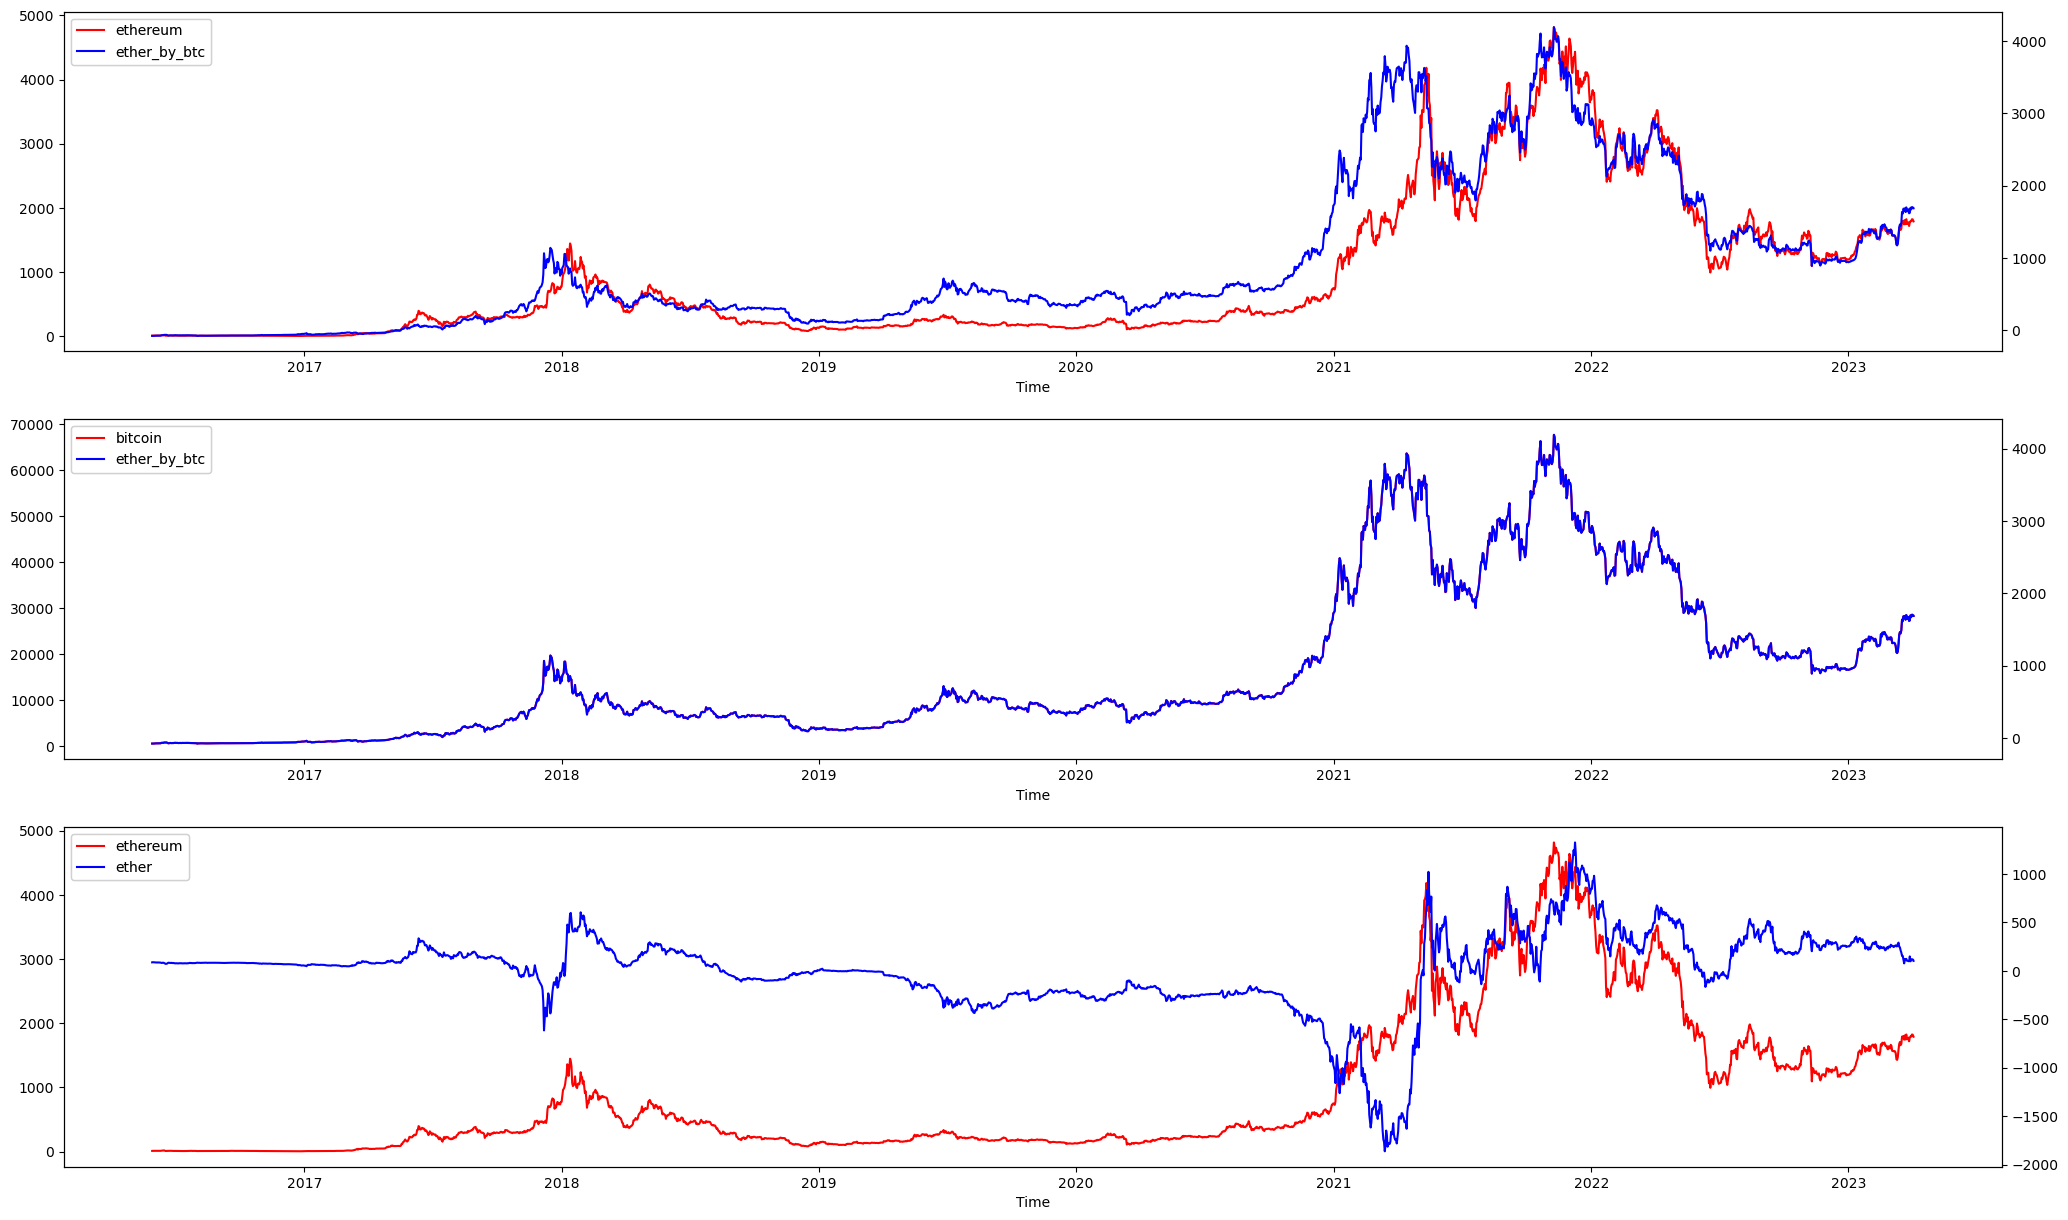

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(25, 15))
x = df.index.values
ethereum = df['ethereum'].values
bitcoin = df['bitcoin'].values
ether_by_btc = df['ether_by_btc'].values
ether = df['ether'].values

##############################################################################
# Посмотрим визуально насколько отличаются значения изначальной стоимости ethereum и посчитанной от bitcoin
# Должно быть немного схоже
ax_0_1 = ax[0].twinx()
line0_1, = ax[0].plot(x, ethereum, color='red', label='ethereum')
line0_2, = ax_0_1.plot(x, ether_by_btc, color='blue', label='ether_by_btc')

legend_0 = ax[0].legend(handles=[line0_1, line0_2], loc='upper left')
ax[0].add_artist(legend_0)
ax[0].set_xlabel('Time')

##############################################################################
# Посмтрим визуально насколько отличаются значения стоимости bitcoin от значений стоимости ethereum посчитанной от bitcoin
# Должно лечь идеально ()
ax_1_1 = ax[1].twinx()
line1_1, = ax[1].plot(x, bitcoin, color='red', label='bitcoin')
line1_2, = ax_1_1.plot(x, ether_by_btc, color='blue', label='ether_by_btc')

legend_1 = ax[1].legend(handles=[line1_1, line1_2], loc='upper left')
ax[1].add_artist(legend_1)
ax[1].set_xlabel('Time')

##############################################################################
#
ax_2_1 = ax[2].twinx()
line2_1, = ax[2].plot(x, ethereum, color='red', label='ethereum')
line2_2, = ax_2_1.plot(x, ether, color='blue', label='ether')

legend_2 = ax[2].legend(handles=[line2_1, line2_2], loc='upper left')
ax[2].add_artist(legend_2)
ax[2].set_xlabel('Time')

In [12]:
pearson = pearsonr(df.ethereum, df.ether_by_btc)
print(f'Correlation coefficient: ', pearson[0])
print(f'P_value: ', pearson[1])

Correlation coefficient:  0.93302378754699
P_value:  0.0


In [13]:
pearson = pearsonr(df.bitcoin, df.ether_by_btc)
print(f'Correlation coefficient: ', pearson[0])
print(f'P_value: ', pearson[1])

Correlation coefficient:  1.0
P_value:  0.0


In [14]:
pearson = pearsonr(df.bitcoin, df.ether)
print(f'Correlation coefficient: ', pearson[0])
print(f'P_value: ', pearson[1])

Correlation coefficient:  -1.478662027890043e-15
P_value:  0.9999999999959351


In [15]:
pearson = pearsonr(df.ethereum, df.ether)
print(f'Correlation coefficient: ', pearson[0])
print(f'P_value: ', pearson[1])

Correlation coefficient:  0.35981469101673497
P_value:  2.556658327479248e-77


In [16]:
coint_t, p_value, crit_value = coint(df.bitcoin, df.ether)
print('T-statistic: ', coint_t)
print(f'P-value in percentage: {round(p_value * 100, 2)}%')
print('Critical values: ', crit_value)

T-statistic:  -1.5960795730263486
P-value in percentage: 72.25%
Critical values:  [-3.90082612 -3.33857513 -3.04614692]


### А теперь напишем функцию, которая в реальном времени следит за ценой фьючерса ETHUSDT, определяет собственные движение цены ETH и при изменении цены на 1% выводит сообщение

In [17]:
def get_coefs(df):
    x = df.bitcoin.values
    y = df.ethereum.values
    lin = np.polyfit(x=x, y=y, deg=1)
    k, c = lin
    return k, c

In [18]:
def get_eth_price_out_btc(btc, eth, k, c, start_price):
    ether_by_btc = k * btc + c
    ether = eth - ether_by_btc
    st_price = start_price - ether_by_btc
    change = abs(ether - st_price) / ether * 100
    return change

In [21]:
k, c = get_coefs(df)
def eye_on_prices():
    start_price = get_current_prices(['ethereum'])['ethereum']
    start_time = time.time()
    while True:
        time.sleep(10)
        curr_prices = get_current_prices(['ethereum', 'bitcoin'])
        changes = get_eth_price_out_btc(btc=curr_prices['bitcoin'], eth=curr_prices['ethereum'], k=k, c=c, start_price=start_price)
        if changes > 1:
            print(f'Ethereum price has changend: {round(changes, 2)} %')
            start_price = curr_prices['ethereum']
            continue
        elif (time.time() - start_time) > (60 * 3600):
            start_price = get_current_price(['ethereum'])['ethereum']
            start_time = time.time()
            continue
        else:
            continue

In [ ]:
eye_on_prices()